# LSTM & Redes Neuronales
En esta sección se realizara buscara darle una solucion al problema por medio de un combinacion de una Long Short Term Memory (LSTM) y una Red Neuronal

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Cargo los datasets

In [14]:
X_dev_full = pd.read_csv('../data/split/X_dev_full.csv', index_col=0)
X_test_full = pd.read_csv('../data/split/X_test_full.csv', index_col=0)
y_dev = pd.read_csv('../data/split/y_dev.csv', index_col=0)
y_test = pd.read_csv('../data/split/y_test.csv', index_col=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Targets que querés predecir
target_cols = [
    "altura_max_m",
    "ganancia_altura_m",
    "duracion_min",
    "distancia_km",
    "velocidad_promedio_kmh",
    "num_termicas",
    "intensidad_termicas_mean_ms",
    "tiempo_en_termicas_min",
    "tasa_ascenso_mean_ms",
]

Usando device: cuda


In [15]:
# Elimino la primera columna de los 4 datasets (indices)
X_dev_full = X_dev_full.iloc[:, 1:]
X_test_full = X_test_full.iloc[:, 1:]
y_dev = y_dev.iloc[:, 1:]
y_test = y_test.iloc[:, 1:]
X_dev_full.head()

,club_2,club_1,club_0,solar_rad_09h,solar_rad_10h,solar_rad_11h,solar_rad_12h,solar_rad_13h,solar_rad_14h,solar_rad_15h,...,precipitation_avg,temp_2m_avg,cloud_cover_avg,wind_u_avg,wind_v_avg,pressure_avg,boundary_layer_height_avg,cape_avg,skin_temp_avg,wind_speed_avg
310,0,0,0,0.0,-0.680824,-0.556270,-0.280646,-0.183173,-0.099961,0.136740,...,0.0,-0.190017,-0.153692,0.521897,0.239152,0.314317,-1.072395,8.627764,-0.476295,-0.597553
59,0,1,0,0.0,-0.608752,-0.388326,-0.117755,-0.096339,-0.126853,-0.014388,...,0.0,-1.382035,-0.327317,2.179702,0.143646,-0.622976,-2.456600,0.000000,-1.384446,-1.381540
163,0,0,1,0.0,0.393822,0.311155,0.328115,0.218754,0.216713,0.351308,...,0.0,0.578625,0.116472,-0.490482,-0.614062,-0.800752,1.109244,0.000000,0.614052,0.624557
54,0,1,0,0.0,-0.795367,-1.052684,-0.689374,-0.544123,-0.564869,-0.360711,...,0.0,-1.109699,-0.327317,-0.037430,-0.767785,0.079621,-1.448753,0.000000,-1.020633,0.532187
267,0,0,1,0.0,0.000000,0.112540,0.202199,0.182017,0.113079,0.269514,...,0.0,0.148860,-0.110964,-0.209813,0.050227,0.185144,0.252901,0.000000,0.095938,0.000000


In [3]:
# -------------------------
# 2) DEFINIR SECUENCIALES Y ESTÁTICAS
# -------------------------

cols = X_dev_full.columns.tolist()

# Horas 09h .. 18h
hours = [f"{h:02d}h" for h in range(9, 19)]  # ['09h', ..., '18h']

# Columnas secuenciales: terminan en _09h, _10h, ..., _18h
seq_cols = [c for c in cols if any(c.endswith(f"_{h}") for h in hours)]

# Prefijos de clima (solar_rad, temp_2m, etc.)
prefixes = sorted({c.rsplit("_", 1)[0] for c in seq_cols})

# Grupos por timestep: para cada hora, las mismas variables en el mismo orden
seq_col_groups = [
    [f"{p}_{h}" for p in prefixes]
    for h in hours
]

# Columnas estáticas = todo lo que NO es secuencial
static_cols = [c for c in cols if c not in seq_cols]

print("Variables secuenciales por timestep:", prefixes)
print("Horas:", hours)
print("N seq features por timestep:", len(prefixes))
print("N static features:", len(static_cols))

Variables secuenciales por timestep: ['boundary_layer_height', 'cape', 'cloud_cover', 'precipitation', 'pressure', 'skin_temp', 'solar_rad', 'temp_2m', 'wind_speed', 'wind_u', 'wind_v']
Horas: ['09h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h']
N seq features por timestep: 11
N static features: 15


In [4]:
# -------------------------
# 3) DATASET PARA LSTM
# -------------------------

class FlightLSTMDataset(Dataset):
    def __init__(self, X_df, y_df, seq_col_groups, static_cols, target_cols):
        self.X = X_df.reset_index(drop=True)
        self.y_df = y_df.reset_index(drop=True)
        self.seq_col_groups = seq_col_groups
        self.static_cols = static_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.X)

    def _row_to_seq(self, row):
        """
        Construye matriz (T, F) para la LSTM sin usar numpy.from_numpy.
        T = nº timesteps (len(hours))
        F = nº features secuenciales (len(prefixes))
        """
        seq_list = []
        for group in self.seq_col_groups:
            # row[group] -> Series con las F variables en esa hora
            vals = row[group].astype("float32").tolist()   # list[float]
            seq_list.append(vals)                          # list[list[float]]

        seq = torch.tensor(seq_list, dtype=torch.float32)  # (T, F)
        return seq

    def __getitem__(self, idx):
        row = self.X.iloc[idx]

        # Secuencia (T, F)
        seq = self._row_to_seq(row)

        # Features estáticas (S,)
        static_vals = row[self.static_cols].astype("float32").tolist()
        static = torch.tensor(static_vals, dtype=torch.float32)

        # Targets (n_targets,)
        y_vals = self.y_df.iloc[idx][self.target_cols].astype("float32").tolist()
        y = torch.tensor(y_vals, dtype=torch.float32)

        return seq, static, y


In [5]:
# -------------------------
# 4) MODELO LSTM + MLP
# -------------------------

class ClimateLSTMRegressor(nn.Module):
    def __init__(
        self,
        seq_input_dim: int,
        static_dim: int,
        n_targets: int,
        hidden_dim: int = 64,
        num_layers: int = 1,
        bidirectional: bool = True,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=seq_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)

        self.mlp = nn.Sequential(
            nn.Linear(lstm_out_dim + static_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_targets),
        )

    def forward(self, seq, static):
        # seq: (batch, T, F), static: (batch, S)
        _, (h_n, _) = self.lstm(seq)  # h_n: (num_layers*num_dirs, batch, hidden_dim)

        if self.bidirectional:
            h_forward = h_n[-2]   # (batch, hidden_dim)
            h_backward = h_n[-1]  # (batch, hidden_dim)
            h_last = torch.cat([h_forward, h_backward], dim=1)  # (batch, 2*hidden_dim)
        else:
            h_last = h_n[-1]  # (batch, hidden_dim)

        x = torch.cat([h_last, static], dim=1)  # (batch, lstm_out_dim + static_dim)
        out = self.mlp(x)  # (batch, n_targets)
        return out

In [6]:
# -------------------------
# 5) FUNCIÓN run_epoch (MSE y R² por target)
# -------------------------

def run_epoch(model, loader, optimizer=None, device=device):
    """
    Si optimizer no es None -> modo train.
    Devuelve:
      - mse_mean: MSE promedio sobre todos los targets
      - r2_mean : R² promedio sobre todos los targets
      - mse_targets_list: lista de MSE por target
      - r2_targets_list : lista de R² por target
    """
    train = optimizer is not None
    model.train() if train else model.eval()

    criterion = nn.MSELoss()

    total_loss = 0.0
    all_y = []
    all_pred = []

    for seq, static, y in loader:
        seq = seq.to(device)
        static = static.to(device)
        y = y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            pred = model(seq, static)
            loss = criterion(pred, y)

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

        total_loss += loss.item() * y.size(0)
        all_y.append(y.detach())
        all_pred.append(pred.detach())

    total_loss /= len(loader.dataset)

    # Concatenamos todo (N, n_targets)
    all_y = torch.cat(all_y, dim=0)
    all_pred = torch.cat(all_pred, dim=0)

    # MSE por target
    mse_targets = ((all_pred - all_y) ** 2).mean(dim=0)       # (T,)
    mse_mean = float(mse_targets.mean().item())

    # R² por target
    y_mean = all_y.mean(dim=0, keepdim=True)
    ss_tot = ((all_y - y_mean) ** 2).sum(dim=0)
    ss_res = ((all_y - all_pred) ** 2).sum(dim=0)
    r2_targets = 1.0 - ss_res / (ss_tot + 1e-8)               # (T,)
    r2_mean = float(r2_targets.mean().item())

    return mse_mean, r2_mean, mse_targets.cpu().tolist(), r2_targets.cpu().tolist()




FOLD 1/5
Epoch 001 | Train Loss=954667.3125, R2=-13.6517 | Val Loss=913877.4375, R2=-13.1627
Epoch 005 | Train Loss=936631.7500, R2=-16.6071 | Val Loss=882305.3750, R2=-25.4281
Epoch 010 | Train Loss=703108.7500, R2=-9.9840 | Val Loss=629199.8750, R2=-6.4819
Epoch 015 | Train Loss=322746.4688, R2=-3.4441 | Val Loss=259260.7500, R2=-1.6086
Epoch 020 | Train Loss=79473.6016, R2=-6.4744 | Val Loss=73958.3359, R2=-2.0812
Epoch 025 | Train Loss=70833.6797, R2=-5.2861 | Val Loss=57854.1914, R2=-2.2365
Epoch 030 | Train Loss=59781.6875, R2=-1.4745 | Val Loss=52297.4258, R2=-0.7442
Epoch 035 | Train Loss=48814.6523, R2=-1.1382 | Val Loss=47794.4258, R2=-0.4126
Epoch 040 | Train Loss=40242.8750, R2=-1.2231 | Val Loss=43502.4688, R2=-0.1855
Epoch 045 | Train Loss=35831.0156, R2=-1.0468 | Val Loss=43660.0859, R2=-0.2251
Epoch 050 | Train Loss=29841.5391, R2=-1.0882 | Val Loss=46190.9453, R2=-0.2655
Epoch 055 | Train Loss=29110.2266, R2=-0.9458 | Val Loss=44935.9336, R2=-0.3982
Epoch 060 | Train 

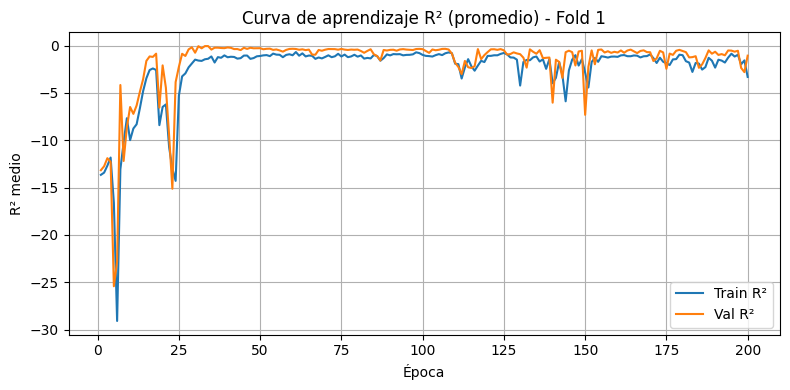

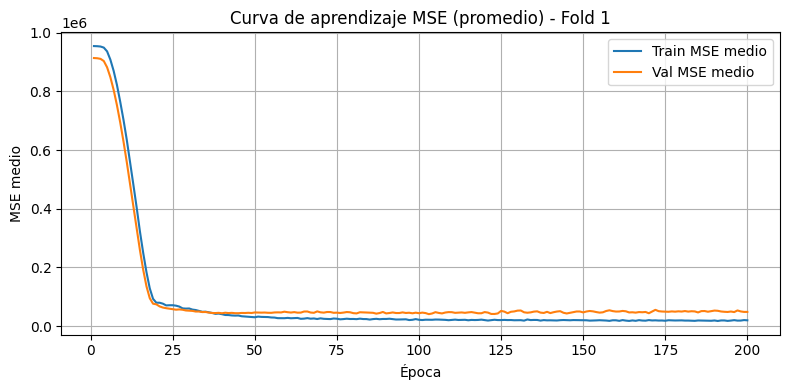

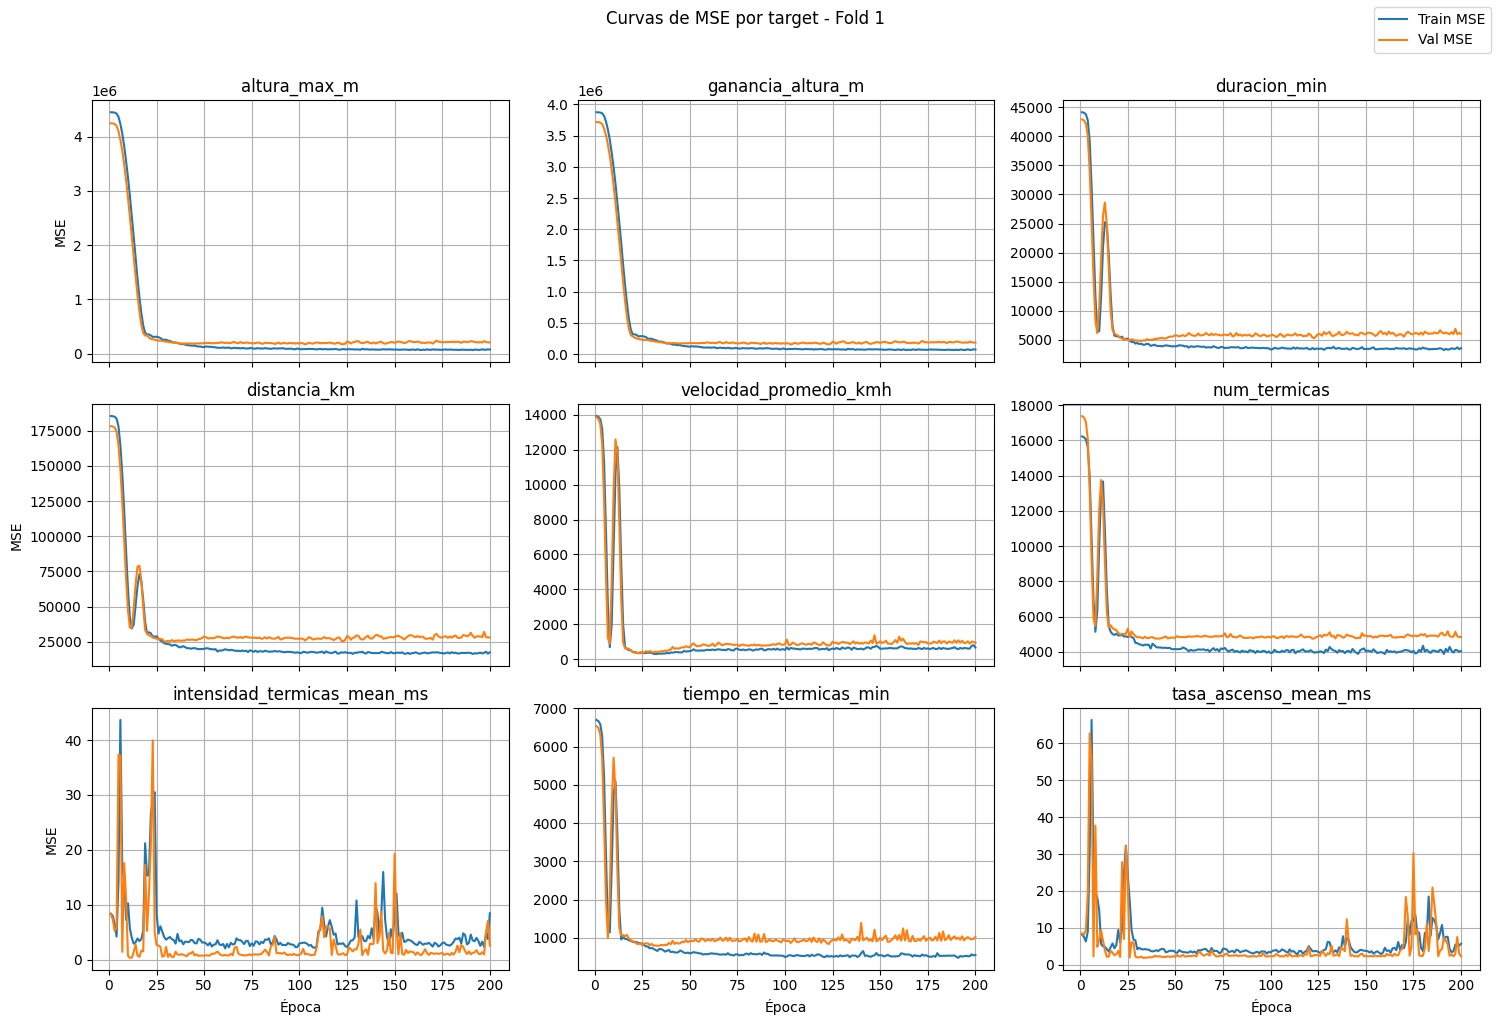

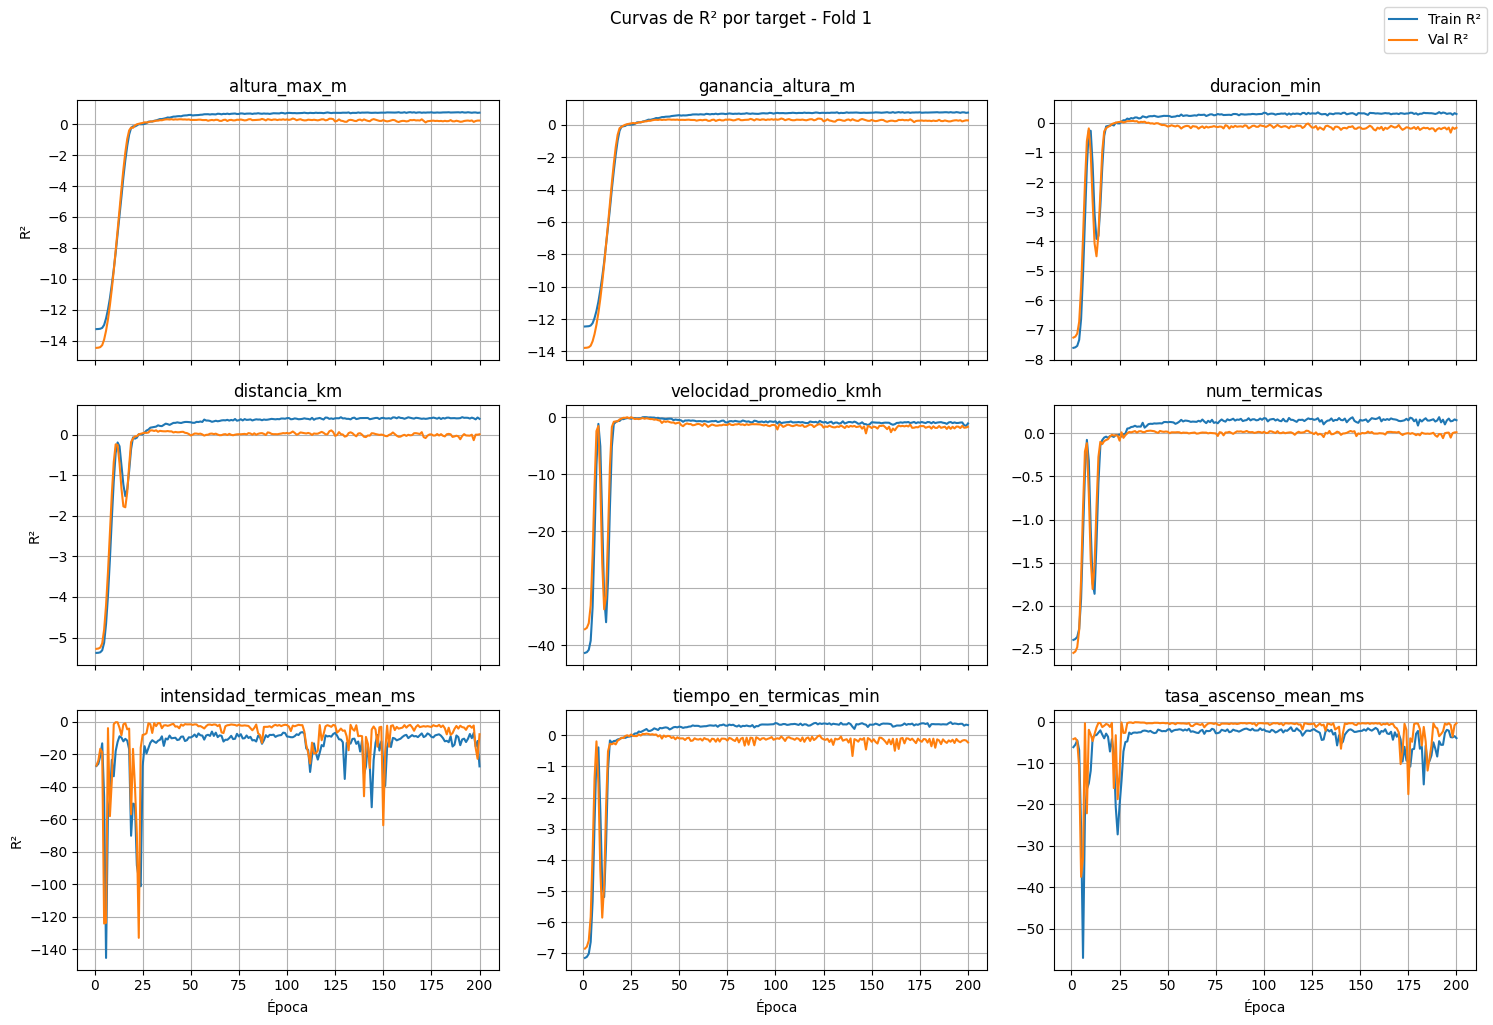


Mejor R² de validación (promedio targets): -0.0418
R² por target en este fold:
  altura_max_m                  : 0.2676
  ganancia_altura_m             : 0.2430
  duracion_min                  : 0.0582
  distancia_km                  : 0.0971
  velocidad_promedio_kmh        : -0.2257
  num_termicas                  : 0.0083
  intensidad_termicas_mean_ms   : -0.7080
  tiempo_en_termicas_min        : 0.0427
  tasa_ascenso_mean_ms          : -0.1592

FOLD 2/5
Epoch 001 | Train Loss=925235.8750, R2=-13.5982 | Val Loss=1030945.1250, R2=-12.3015
Epoch 005 | Train Loss=907646.7500, R2=-15.0803 | Val Loss=997976.8750, R2=-20.3022
Epoch 010 | Train Loss=630678.1250, R2=-9.3089 | Val Loss=674085.7500, R2=-6.1727
Epoch 015 | Train Loss=214062.4688, R2=-2.9331 | Val Loss=225215.0000, R2=-0.6836
Epoch 020 | Train Loss=66948.0000, R2=-13.9748 | Val Loss=96270.0781, R2=-13.3780
Epoch 025 | Train Loss=59095.1445, R2=-10.7566 | Val Loss=90406.6562, R2=-8.6238
Epoch 030 | Train Loss=47168.5898, R2=-5.0

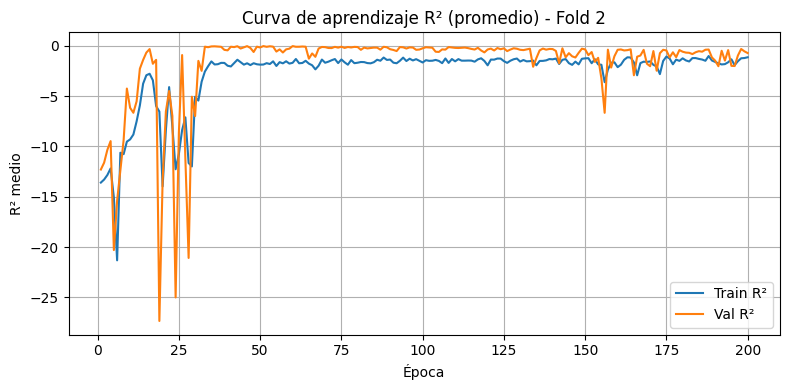

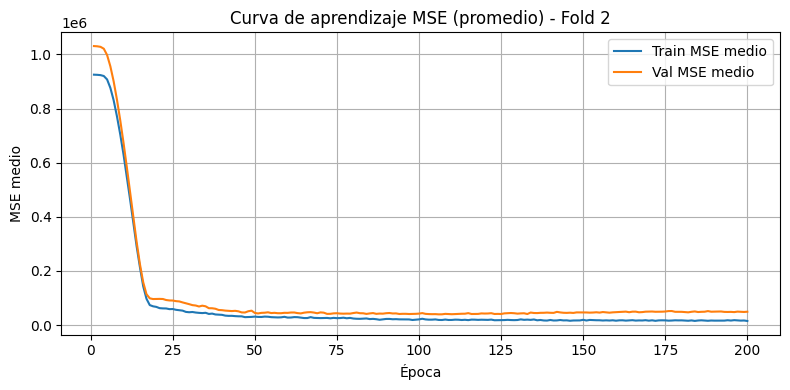

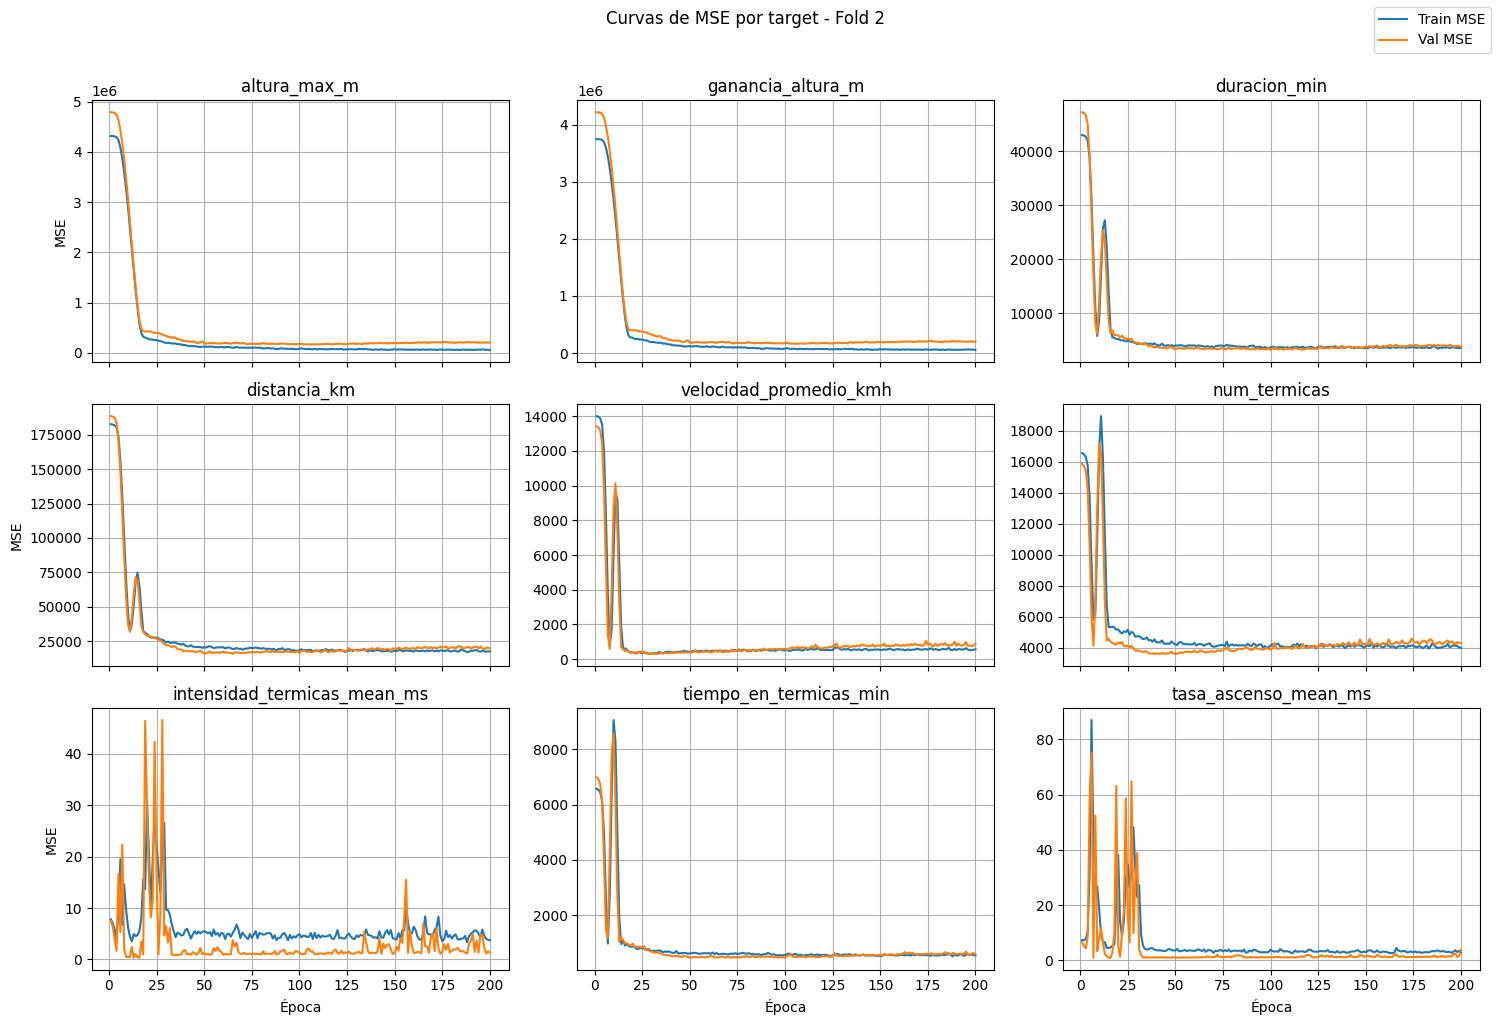

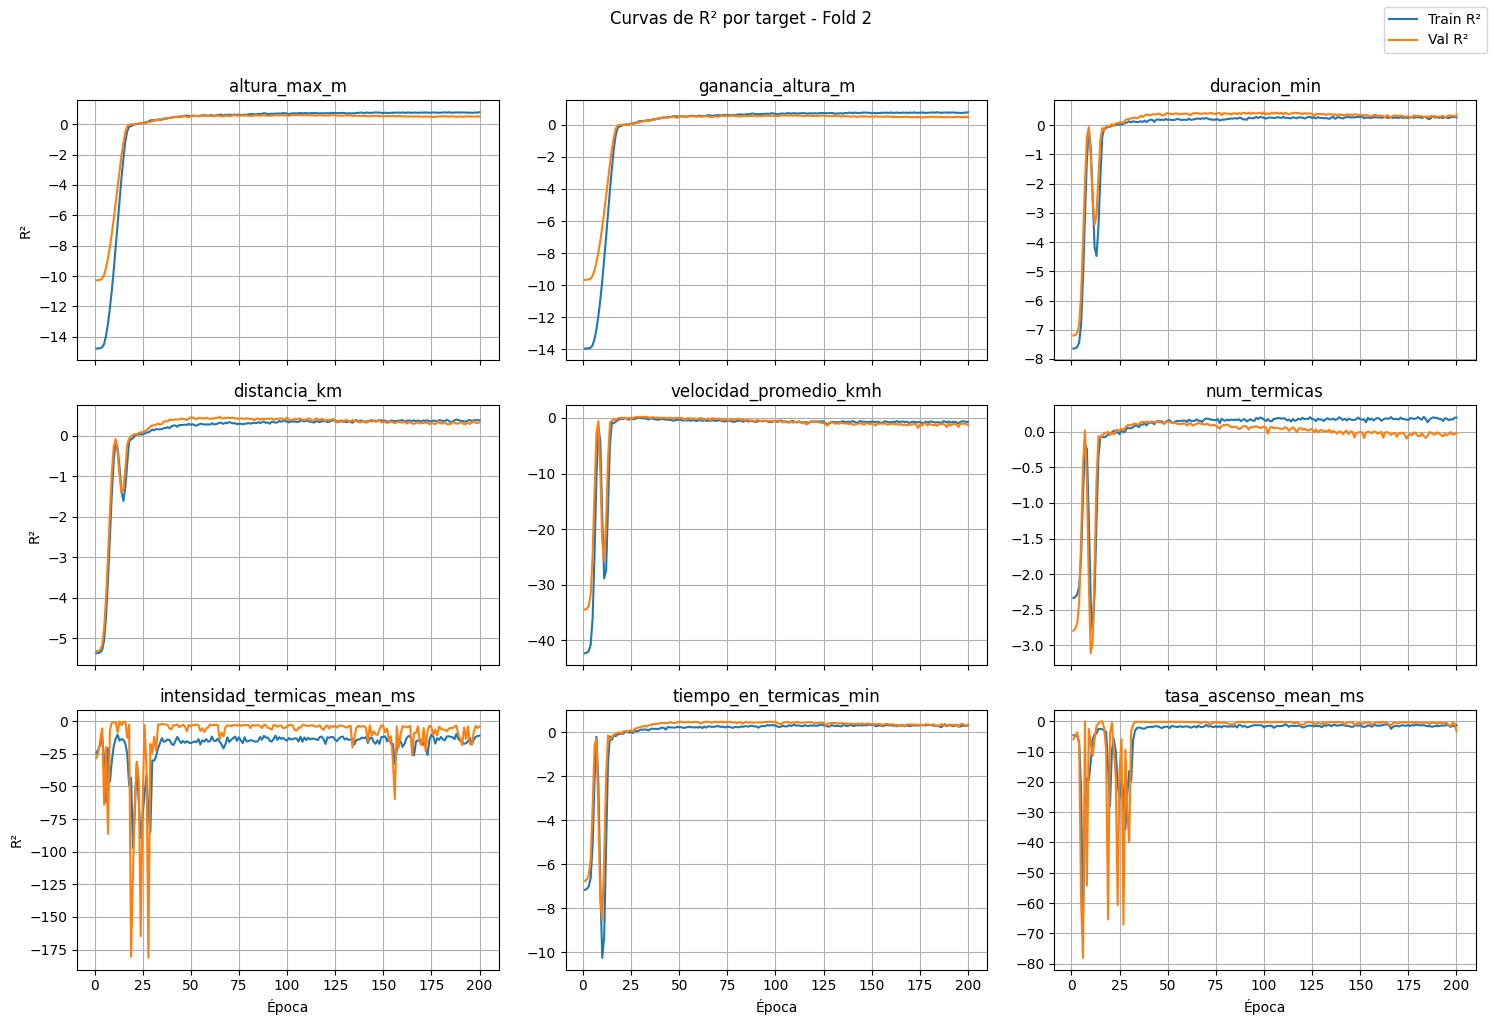


Mejor R² de validación (promedio targets): -0.0384
R² por target en este fold:
  altura_max_m                  : 0.5696
  ganancia_altura_m             : 0.5501
  duracion_min                  : 0.3907
  distancia_km                  : 0.4542
  velocidad_promedio_kmh        : -0.0292
  num_termicas                  : 0.1350
  intensidad_termicas_mean_ms   : -2.7453
  tiempo_en_termicas_min        : 0.4673
  tasa_ascenso_mean_ms          : -0.1381

FOLD 3/5
Epoch 001 | Train Loss=934233.3125, R2=-12.8488 | Val Loss=994344.1250, R2=-16.7759
Epoch 005 | Train Loss=908818.8125, R2=-17.8994 | Val Loss=951094.6875, R2=-19.3427
Epoch 010 | Train Loss=610925.9375, R2=-8.2916 | Val Loss=607264.8125, R2=-7.3825
Epoch 015 | Train Loss=186702.3125, R2=-3.2081 | Val Loss=158523.0312, R2=-1.2170
Epoch 020 | Train Loss=73553.3594, R2=-17.0841 | Val Loss=61897.4453, R2=-0.3469
Epoch 025 | Train Loss=66358.8047, R2=-2.6654 | Val Loss=52810.4219, R2=-0.0593
Epoch 030 | Train Loss=56392.2969, R2=-2.1811

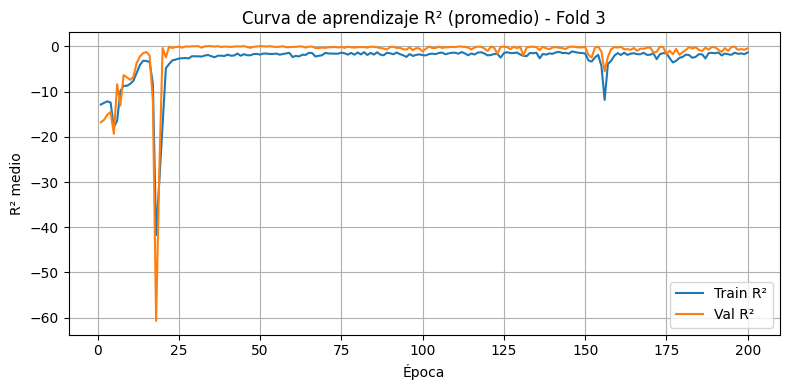

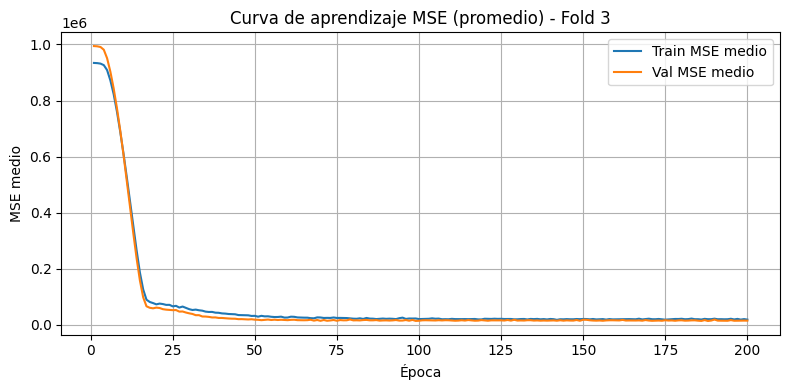

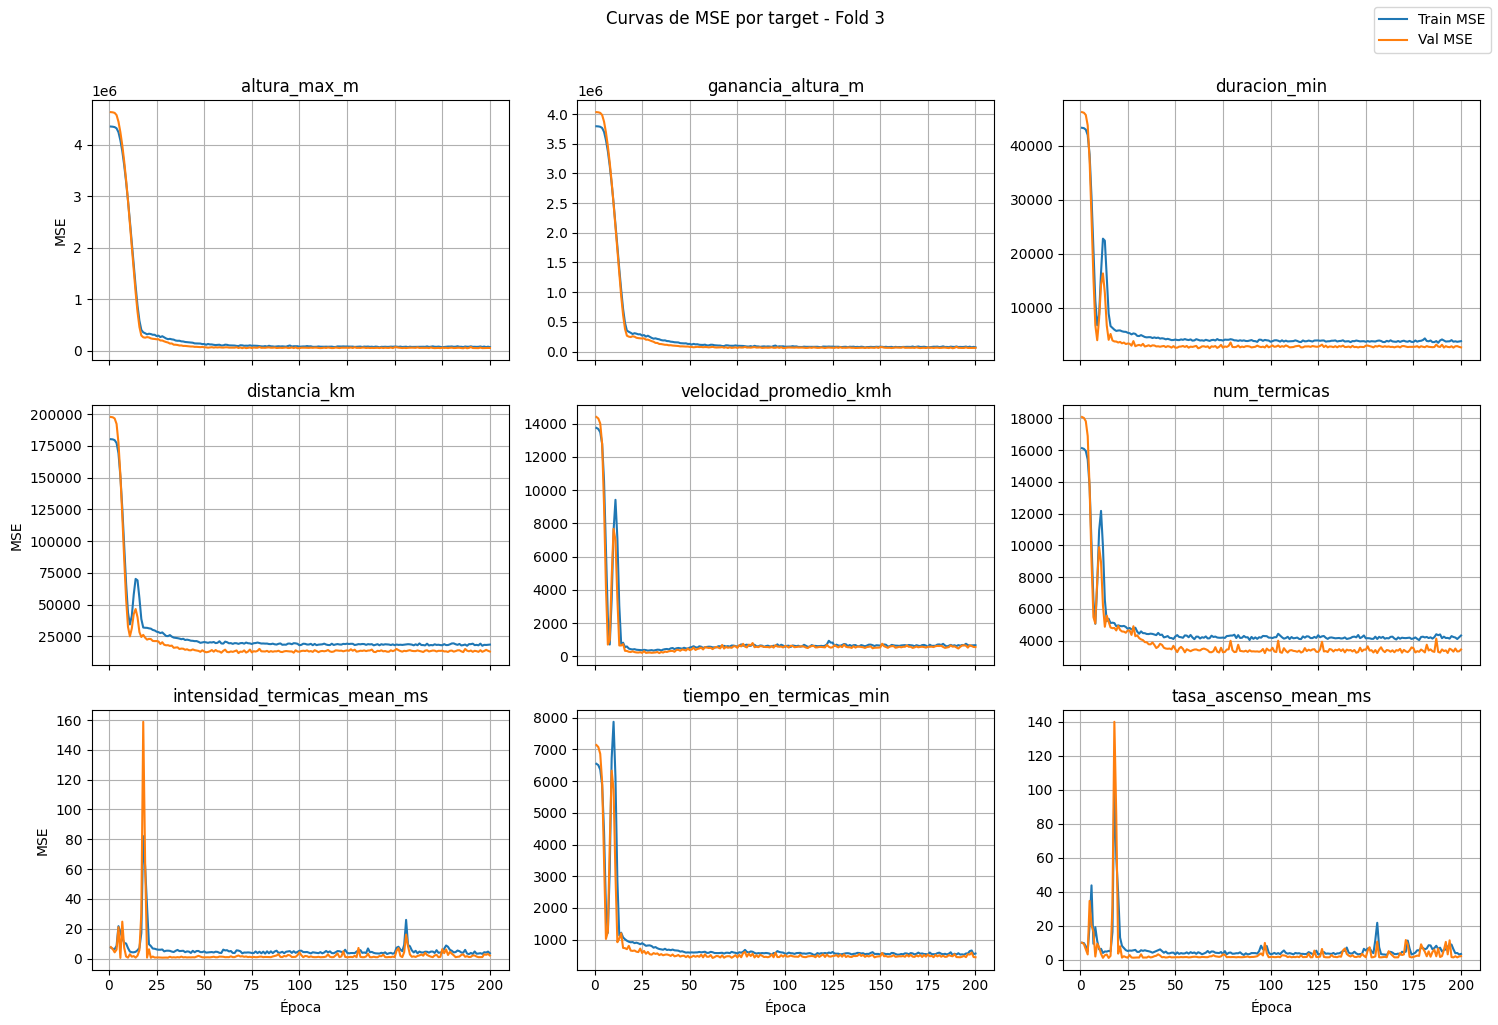

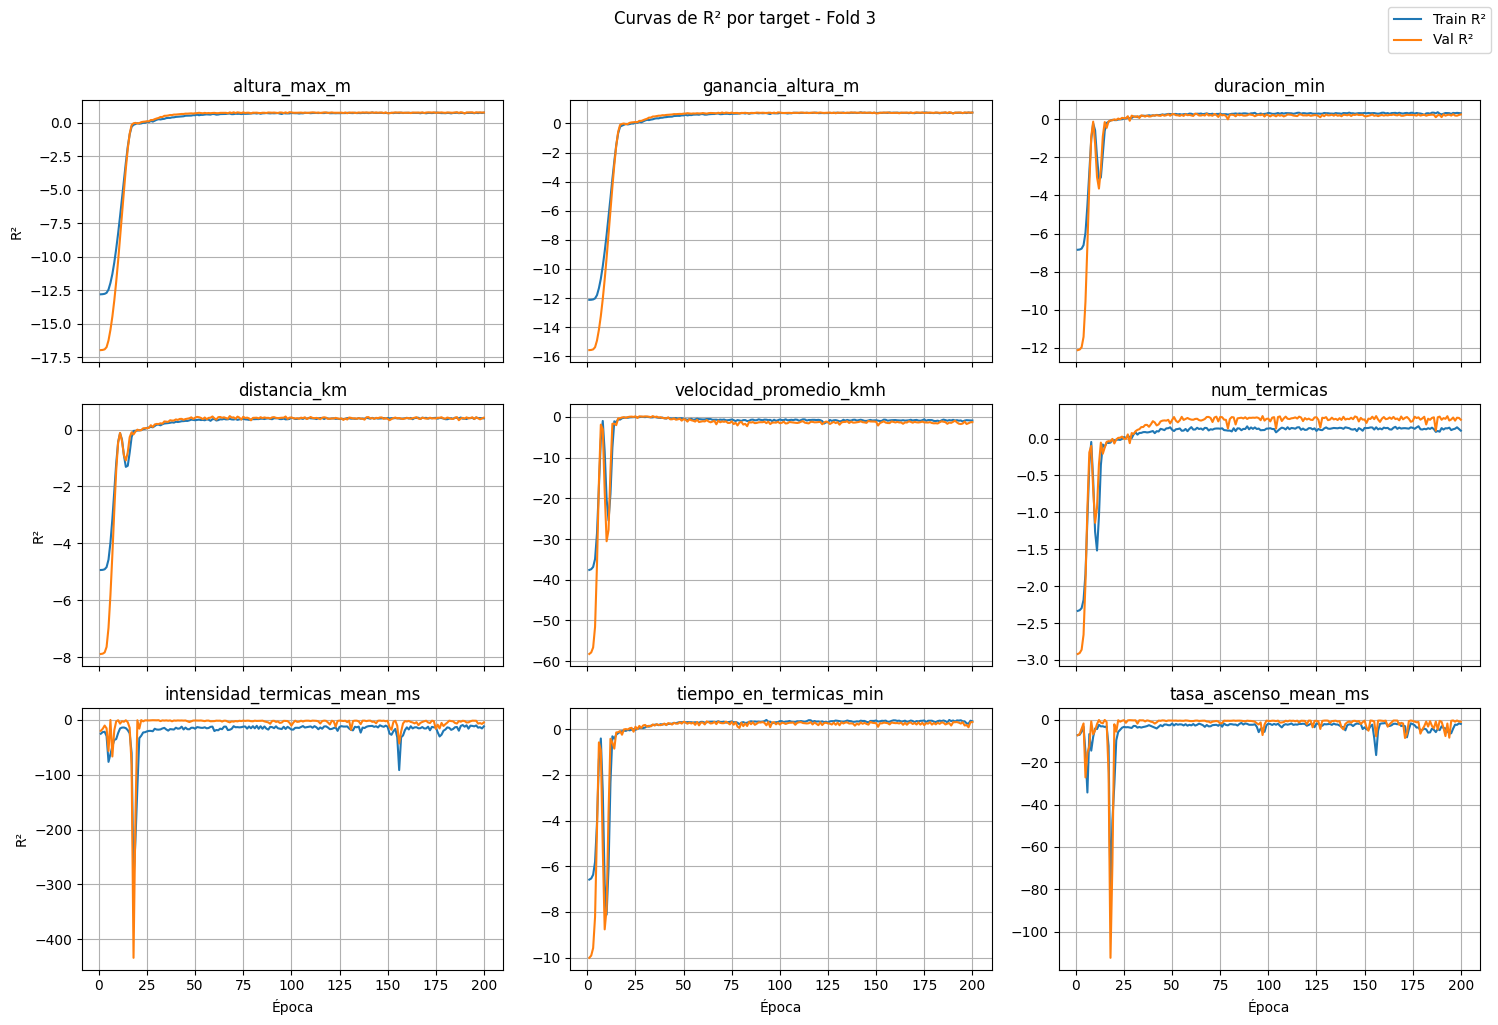


Mejor R² de validación (promedio targets): 0.0849
R² por target en este fold:
  altura_max_m                  : 0.6919
  ganancia_altura_m             : 0.6450
  duracion_min                  : 0.2341
  distancia_km                  : 0.3686
  velocidad_promedio_kmh        : -0.3495
  num_termicas                  : 0.2425
  intensidad_termicas_mean_ms   : -1.1640
  tiempo_en_termicas_min        : 0.2806
  tasa_ascenso_mean_ms          : -0.1851

FOLD 4/5
Epoch 001 | Train Loss=926707.4375, R2=-13.2336 | Val Loss=1024893.7500, R2=-12.0010
Epoch 005 | Train Loss=907470.9375, R2=-36.8226 | Val Loss=988889.3125, R2=-56.7908
Epoch 010 | Train Loss=666845.0625, R2=-14.0086 | Val Loss=704591.8750, R2=-12.1611
Epoch 015 | Train Loss=278334.5625, R2=-3.6824 | Val Loss=279696.8750, R2=-1.2696
Epoch 020 | Train Loss=72000.4375, R2=-10.7485 | Val Loss=76625.3906, R2=-21.2553
Epoch 025 | Train Loss=60873.1602, R2=-6.4486 | Val Loss=65789.4688, R2=-0.2549
Epoch 030 | Train Loss=48792.2188, R2=-1.6

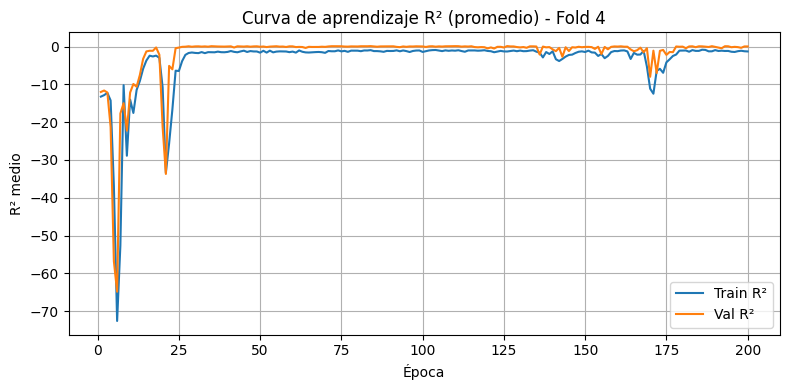

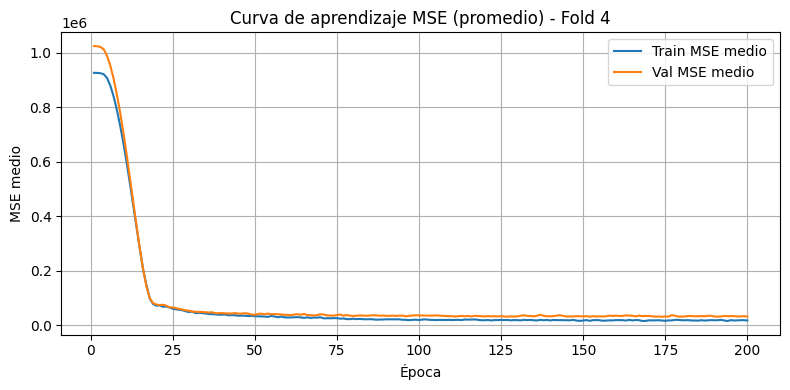

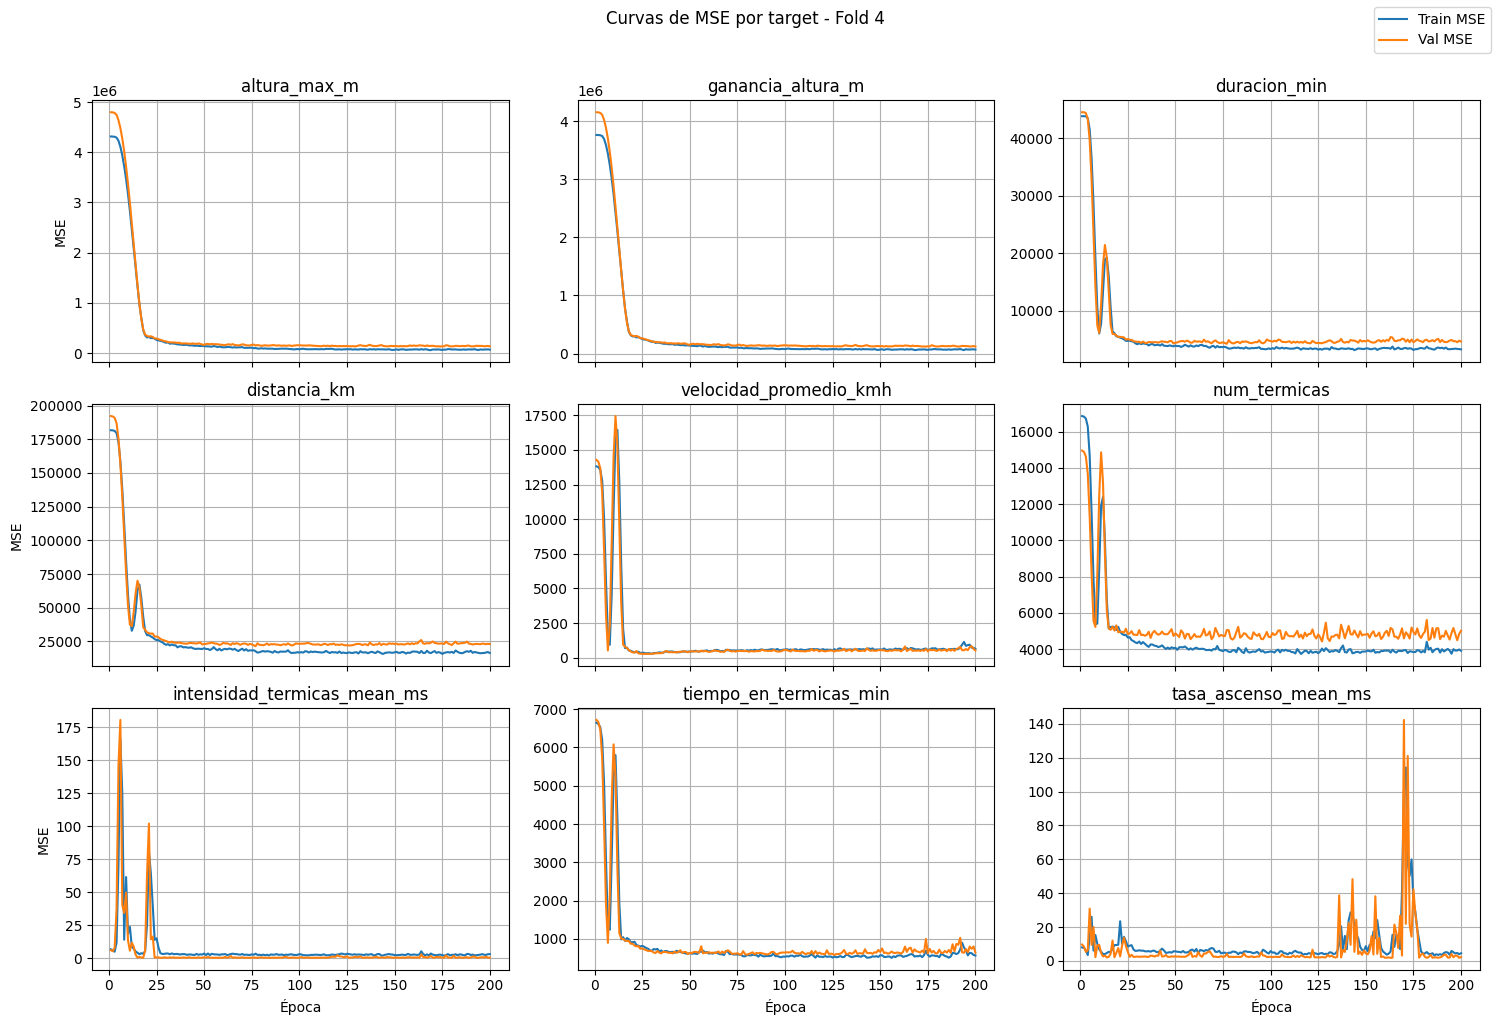

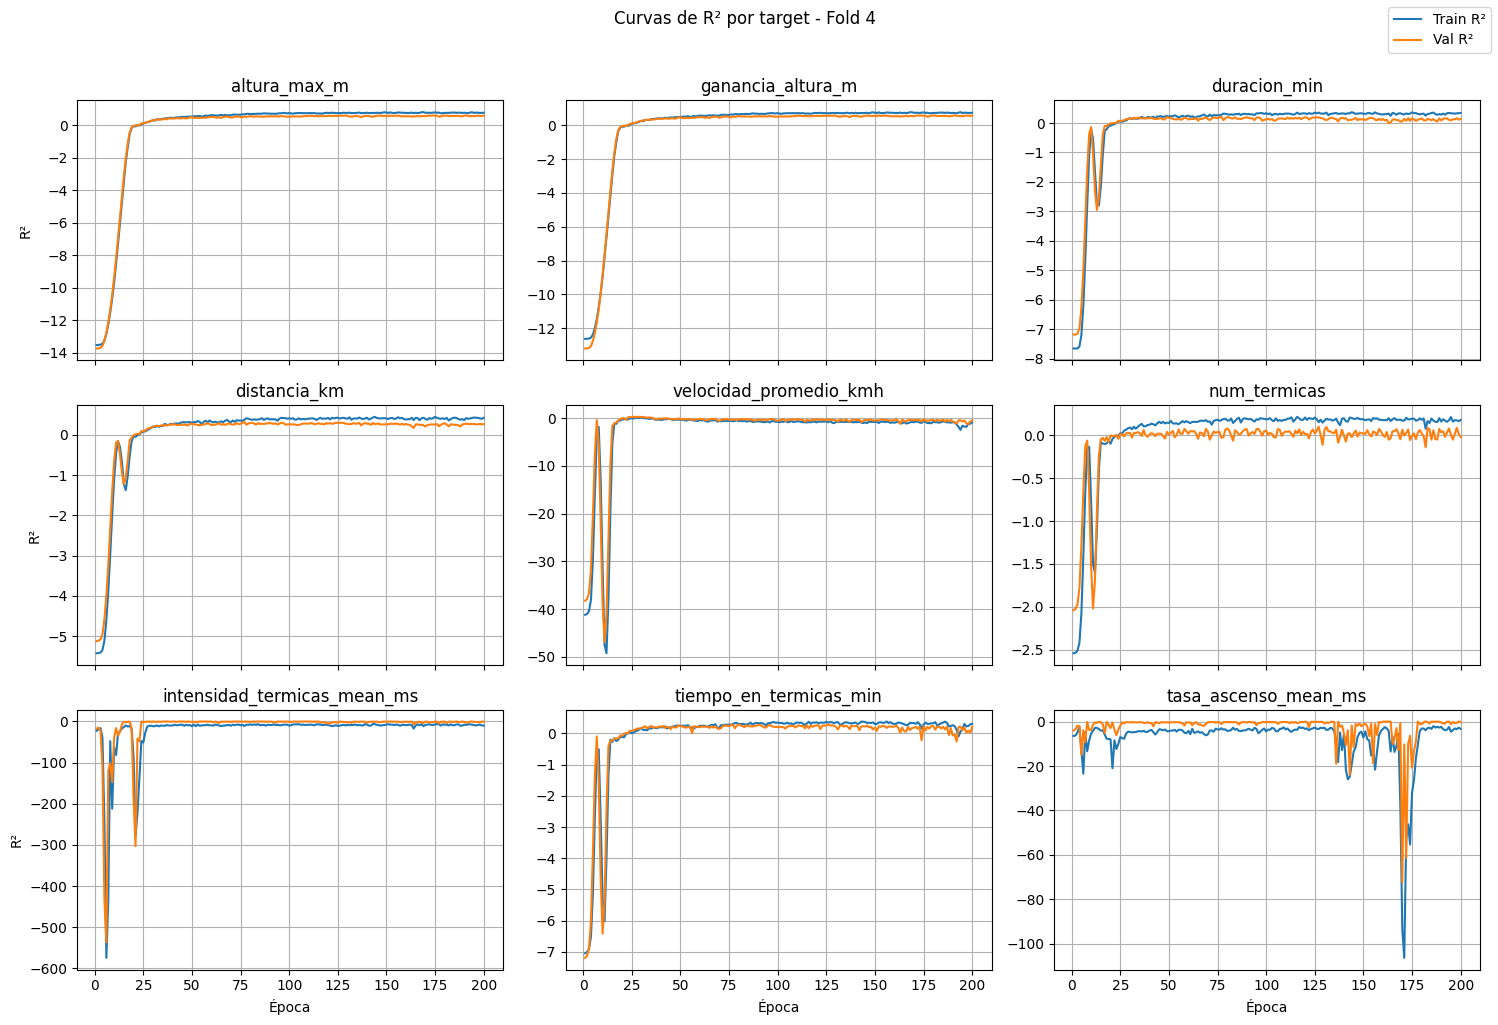


Mejor R² de validación (promedio targets): 0.1464
R² por target en este fold:
  altura_max_m                  : 0.5804
  ganancia_altura_m             : 0.5767
  duracion_min                  : 0.1886
  distancia_km                  : 0.2977
  velocidad_promedio_kmh        : -0.2396
  num_termicas                  : 0.0534
  intensidad_termicas_mean_ms   : -0.3542
  tiempo_en_termicas_min        : 0.2879
  tasa_ascenso_mean_ms          : -0.0729

FOLD 5/5
Epoch 001 | Train Loss=991184.6875, R2=-13.3145 | Val Loss=764220.0000, R2=-15.8746
Epoch 005 | Train Loss=976416.6875, R2=-15.6468 | Val Loss=739926.6875, R2=-33.0743
Epoch 010 | Train Loss=727675.2500, R2=-8.7194 | Val Loss=496971.5625, R2=-8.8210
Epoch 015 | Train Loss=309089.5938, R2=-2.9429 | Val Loss=155247.3438, R2=-1.8544
Epoch 020 | Train Loss=80992.7188, R2=-4.2617 | Val Loss=64803.5820, R2=-6.2611
Epoch 025 | Train Loss=61769.0625, R2=-8.8165 | Val Loss=55860.9414, R2=-24.9411
Epoch 030 | Train Loss=48988.8281, R2=-2.7850 

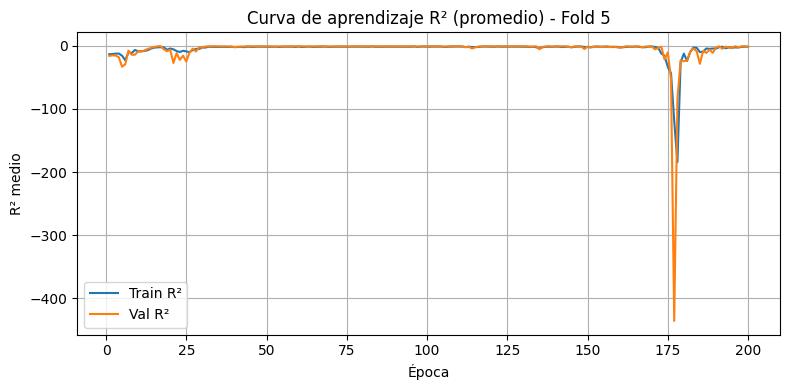

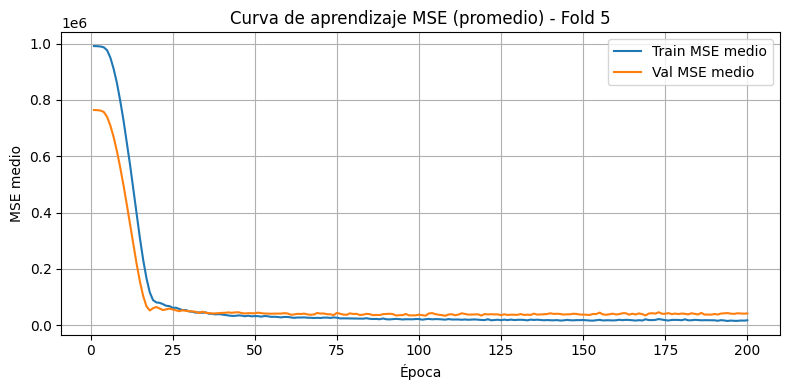

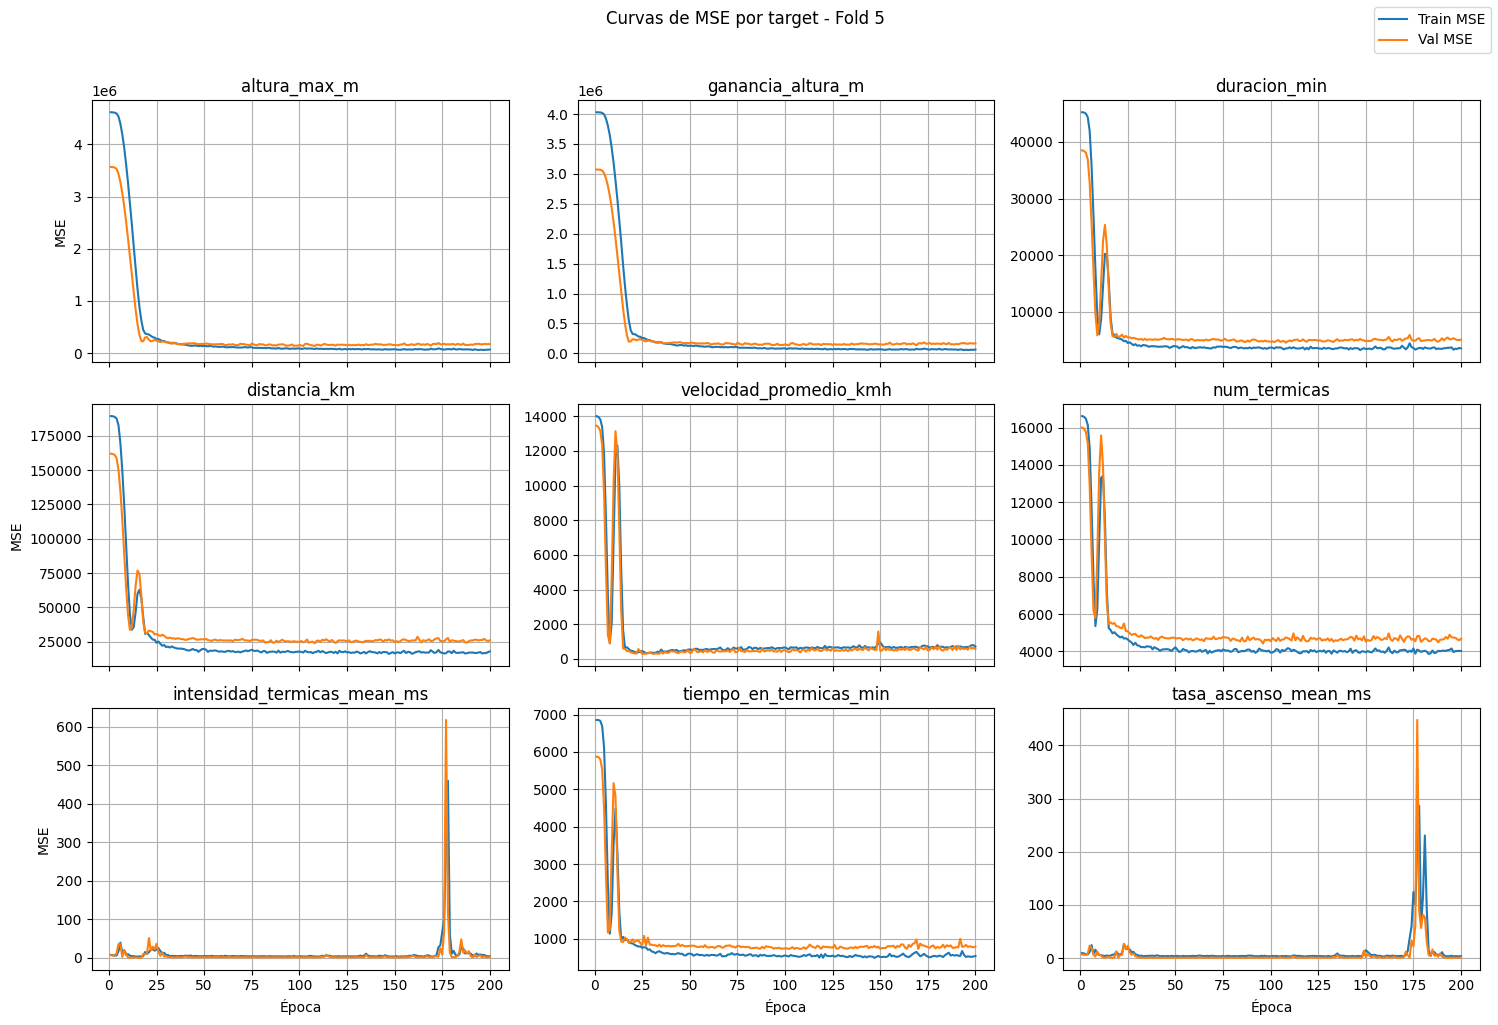

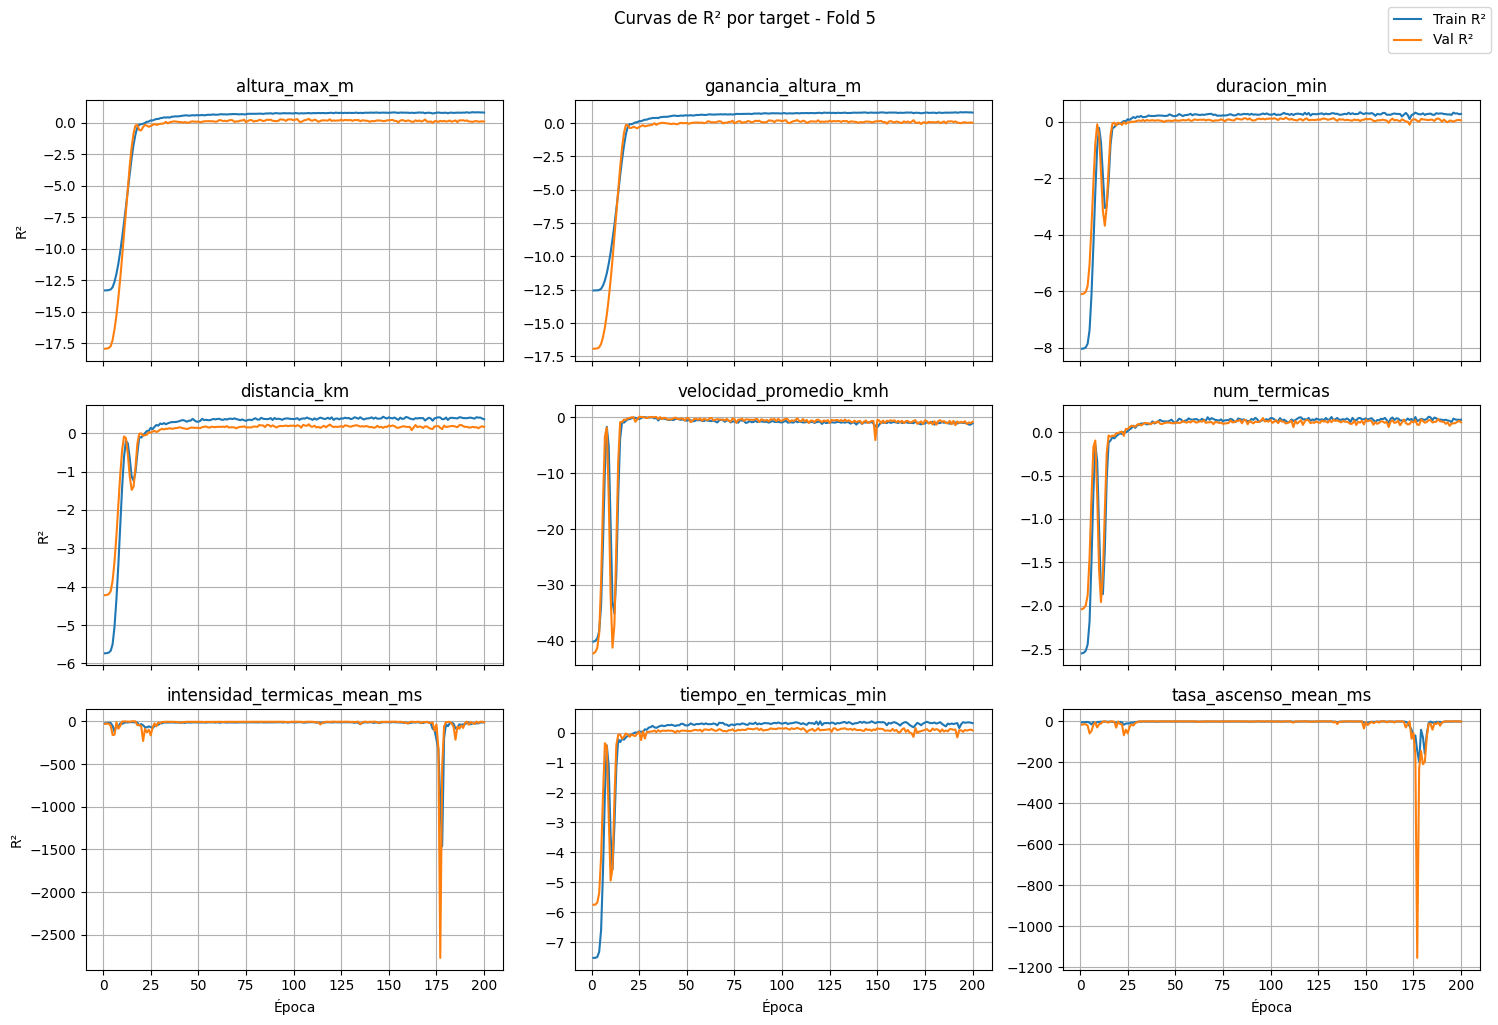


Mejor R² de validación (promedio targets): -0.4212
R² por target en este fold:
  altura_max_m                  : -0.2291
  ganancia_altura_m             : -0.7546
  duracion_min                  : -0.0599
  distancia_km                  : -0.9013
  velocidad_promedio_kmh        : -0.4197
  num_termicas                  : -0.0404
  intensidad_termicas_mean_ms   : -0.3983
  tiempo_en_termicas_min        : -0.1316
  tasa_ascenso_mean_ms          : -0.8560


In [16]:
# -------------------------
# 6) CROSS-VALIDATION + CURVAS
# -------------------------

n_splits = 5
batch_size = 32
n_epochs = 200
lr = 1e-3
weight_decay = 1e-5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = []  # guardará R² por target en cada fold

seq_input_dim = len(prefixes)
static_dim = len(static_cols)
n_targets = len(target_cols)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_dev_full)):
    print("\n" + "="*70)
    print(f"FOLD {fold+1}/{n_splits}")
    print("="*70)

    X_tr = X_dev_full.iloc[train_idx].reset_index(drop=True)
    y_tr = y_dev.iloc[train_idx].reset_index(drop=True)
    X_va = X_dev_full.iloc[val_idx].reset_index(drop=True)
    y_va = y_dev.iloc[val_idx].reset_index(drop=True)

    train_ds = FlightLSTMDataset(X_tr, y_tr, seq_col_groups, static_cols, target_cols)
    val_ds   = FlightLSTMDataset(X_va, y_va, seq_col_groups, static_cols, target_cols)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size*2, shuffle=False)

    # Modelo nuevo por fold
    model = ClimateLSTMRegressor(
        seq_input_dim=seq_input_dim,
        static_dim=static_dim,
        n_targets=n_targets,
        hidden_dim=64,
        num_layers=1,
        bidirectional=True,
        dropout=0.1,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_r2 = -1e9
    best_state = None

    # Historial para curvas globales
    history_train_r2 = []
    history_val_r2 = []
    history_train_loss = []
    history_val_loss = []

    # Historial por target
    history_train_loss_targets = []  # list of [MSE_t1, ..., MSE_t9]
    history_val_loss_targets = []
    history_train_r2_targets = []
    history_val_r2_targets = []

    for epoch in range(1, n_epochs + 1):
        train_loss, train_r2, train_mse_t, train_r2_t = run_epoch(
            model, train_loader, optimizer=optimizer, device=device
        )
        val_loss, val_r2, val_mse_t, val_r2_t = run_epoch(
            model, val_loader, optimizer=None, device=device
        )

        # Guardar historial global
        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        history_train_r2.append(train_r2)
        history_val_r2.append(val_r2)

        # Guardar historial por target
        history_train_loss_targets.append(train_mse_t)
        history_val_loss_targets.append(val_mse_t)
        history_train_r2_targets.append(train_r2_t)
        history_val_r2_targets.append(val_r2_t)

        # Guardar mejor estado según R² promedio de validación
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:03d} | "
                f"Train Loss={train_loss:.4f}, R2={train_r2:.4f} | "
                f"Val Loss={val_loss:.4f}, R2={val_r2:.4f}"
            )

    # ---- Curvas de aprendizaje global (promedio sobre targets) ----
    epochs_axis = range(1, n_epochs + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(epochs_axis, history_train_r2, label="Train R²")
    plt.plot(epochs_axis, history_val_r2, label="Val R²")
    plt.xlabel("Época")
    plt.ylabel("R² medio")
    plt.title(f"Curva de aprendizaje R² (promedio) - Fold {fold+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(epochs_axis, history_train_loss, label="Train MSE medio")
    plt.plot(epochs_axis, history_val_loss, label="Val MSE medio")
    plt.xlabel("Época")
    plt.ylabel("MSE medio")
    plt.title(f"Curva de aprendizaje MSE (promedio) - Fold {fold+1}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- Curvas por target: MSE ----
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i, target_name in enumerate(target_cols):
        ax = axes[i]
        train_vals = [ep[i] for ep in history_train_loss_targets]
        val_vals   = [ep[i] for ep in history_val_loss_targets]

        ax.plot(epochs_axis, train_vals, label="Train MSE")
        ax.plot(epochs_axis, val_vals,   label="Val MSE")
        ax.set_title(target_name)
        ax.grid(True)

        if i % 3 == 0:
            ax.set_ylabel("MSE")
        if i // 3 == 2:
            ax.set_xlabel("Época")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"Curvas de MSE por target - Fold {fold+1}", y=1.02)
    plt.tight_layout()
    plt.show()

    # ---- Curvas por target: R² ----
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()

    for i, target_name in enumerate(target_cols):
        ax = axes[i]
        train_vals = [ep[i] for ep in history_train_r2_targets]
        val_vals   = [ep[i] for ep in history_val_r2_targets]

        ax.plot(epochs_axis, train_vals, label="Train R²")
        ax.plot(epochs_axis, val_vals,   label="Val R²")
        ax.set_title(target_name)
        ax.grid(True)

        if i % 3 == 0:
            ax.set_ylabel("R²")
        if i // 3 == 2:
            ax.set_xlabel("Época")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    fig.suptitle(f"Curvas de R² por target - Fold {fold+1}", y=1.02)
    plt.tight_layout()
    plt.show()

    # ---- Evaluar mejor modelo del fold en validación ----
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    _, val_r2_final, _, val_r2_targets = run_epoch(
        model, val_loader, optimizer=None, device=device
    )

    print("\nMejor R² de validación (promedio targets):", f"{val_r2_final:.4f}")
    print("R² por target en este fold:")
    for name, r2v in zip(target_cols, val_r2_targets):
        print(f"  {name:30s}: {r2v:.4f}")

    fold_results.append(val_r2_targets)

In [17]:
# -------------------------
# 7) RESUMEN FINAL CV
# -------------------------

fold_results = np.vstack(fold_results)  # (n_splits, n_targets)

print("\n" + "="*70)
print("RESUMEN CROSS-VALIDATION (LSTM+MLP)")
print("="*70)

mean_r2_targets = fold_results.mean(axis=0)
std_r2_targets = fold_results.std(axis=0)

for name, mu, sd in zip(target_cols, mean_r2_targets, std_r2_targets):
    print(f"{name:30s}: R² CV medio = {mu:.4f} ± {sd:.4f}")

print("-" * 70)
print("R² CV PROMEDIO (sobre todos los targets):", f"{mean_r2_targets.mean():.4f}")
print("="*70)


RESUMEN CROSS-VALIDATION (LSTM+MLP)
altura_max_m                  : R² CV medio = 0.3761 ± 0.3337
ganancia_altura_m             : R² CV medio = 0.2520 ± 0.5219
duracion_min                  : R² CV medio = 0.1623 ± 0.1538
distancia_km                  : R² CV medio = 0.0633 ± 0.4965
velocidad_promedio_kmh        : R² CV medio = -0.2527 ± 0.1327
num_termicas                  : R² CV medio = 0.0798 ± 0.0998
intensidad_termicas_mean_ms   : R² CV medio = -1.0740 ± 0.8843
tiempo_en_termicas_min        : R² CV medio = 0.1894 ± 0.2097
tasa_ascenso_mean_ms          : R² CV medio = -0.2823 ± 0.2893
----------------------------------------------------------------------
R² CV PROMEDIO (sobre todos los targets): -0.0540
